In [13]:
import os
import sys
import numpy as np
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import math

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH, FIGURES_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import (
    draw_temporal_final,
    draw_cumulative,
    draw_temporal_final2,
)
import experiments.utils.drawing

In [14]:
BURSTY = "Bursty"
STEADY_LOW = "Steady Low"
STEADY_HIGH = "Steady High"
FLUCTUATING = "Fluctuating"

series_load_type = {
    21: BURSTY,
    22: BURSTY,
    23: BURSTY,
    # 24: BURSTY,
    25: BURSTY,
    26: STEADY_LOW,
    27: STEADY_LOW,
    28: STEADY_LOW,
    # 29: STEADY_LOW,
    30: STEADY_LOW,
    31: STEADY_HIGH,
    32: STEADY_HIGH,
    33: STEADY_HIGH,
    # 34: STEADY_HIGH,
    35: STEADY_HIGH,
    36: FLUCTUATING,
    37: FLUCTUATING,
    38: FLUCTUATING,
    # 39: FLUCTUATING,
    40: FLUCTUATING,
}
series_names = {
    21: "IPA",
    22: "FA2-low",
    23: "FA2-high",
    # 24: "RIM-low",
    # 25: "RIM-high",
    25: "RIM",
    26: "IPA",
    27: "FA2-low",
    28: "FA2-high",
    # 29: "RIM-low",
    # 30: "RIM-high",
    30: "RIM",
    31: "IPA",
    32: "FA2-low",
    33: "FA2-high",
    # 34: "RIM-low",
    # 35: "RIM-high",
    35: "RIM",
    36: "IPA",
    37: "FA2-low",
    38: "FA2-high",
    # 39: "RIM-low",
    # 40: "RIM-high",
    40: "RIM",
}

metaseries = 30
load_series = {BURSTY: [], STEADY_LOW: [], STEADY_HIGH: [], FLUCTUATING: []}
for serie, load_type in series_load_type.items():
    load_series[load_type].append(serie)

pipeline_name = "audio-qa"
series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series in series_names.keys()
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [15]:
loaders

{21: <experiments.utils.parser.AdaptationParser at 0x7fa6d6e860a0>,
 22: <experiments.utils.parser.AdaptationParser at 0x7fa6d6e86280>,
 23: <experiments.utils.parser.AdaptationParser at 0x7fa6df38bf40>,
 25: <experiments.utils.parser.AdaptationParser at 0x7fa6d97a1880>,
 26: <experiments.utils.parser.AdaptationParser at 0x7fa6e41f4d00>,
 27: <experiments.utils.parser.AdaptationParser at 0x7fa6e41f4c40>,
 28: <experiments.utils.parser.AdaptationParser at 0x7fa7b06bb340>,
 30: <experiments.utils.parser.AdaptationParser at 0x7fa7b06bb790>,
 31: <experiments.utils.parser.AdaptationParser at 0x7fa6df381670>,
 32: <experiments.utils.parser.AdaptationParser at 0x7fa6df381c70>,
 33: <experiments.utils.parser.AdaptationParser at 0x7fa6d6ea7cd0>,
 35: <experiments.utils.parser.AdaptationParser at 0x7fa6e41bcdf0>,
 36: <experiments.utils.parser.AdaptationParser at 0x7fa6d98c45b0>,
 37: <experiments.utils.parser.AdaptationParser at 0x7fa6db242430>,
 38: <experiments.utils.parser.AdaptationParser 

In [16]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 21 config:

{   'accuracy_method': 'multiply',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 10,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 1,
    'benchmark_duration': 1,
    'beta': 0.5,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 20,
    'from_storage': [True, True],
    'gamma': 1e-06,
    'initial_active_model': [   'facebook-s2t-small-librispeech-asr',
                                'deepset-roberta-base-squad2'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 100,
    'logs_enabled': False,
    'lowest_model_accuracy': 0.05,
    'metadata': 'bursty - ipa - cpu type: compute_cascadelake_r_ib - redo of '
                'metaseries bursty on chameleon to check latencies',
    'metaseries': 30,
    'mode': 'exponential',
    'model_name': ['audi

In [17]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [18]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{21: False,
 22: False,
 23: False,
 25: False,
 26: False,
 27: False,
 28: False,
 30: False,
 31: False,
 32: False,
 33: False,
 35: False,
 36: False,
 37: False,
 38: False,
 40: False}

In [19]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [20]:
series_changes = {}
for series in series_names.keys():
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Comparing Predicted Load with the Recieved Load

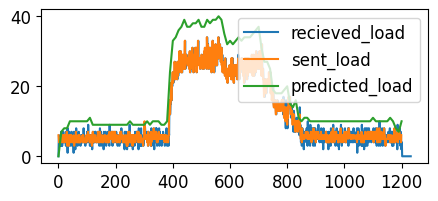

In [21]:
first_sereis = list(series_changes.keys())[
    0
]  # load should be roughly similar among the series
recieved_load = series_changes[first_sereis]["recieved_load"]
recieved_load_x = [x for x in range(0, len(recieved_load))]
predicted_load = series_changes[first_sereis]["predicted_load"]
predicted_load_x = series_changes[first_sereis]["time_interval"]
sent_load = sent_loads[first_sereis]
sent_load_x = [x for x in range(0, len(sent_loads[first_sereis]))]


plt.figure(figsize=(5, 2))
plt.plot(recieved_load_x, recieved_load, label="recieved_load")
plt.plot(sent_load_x, sent_load, label="sent_load")
plt.plot(predicted_load_x, predicted_load, label="predicted_load")
# TODO add predicted reference load here
plt.legend()
plt.show()

In [22]:
final_dict = {}
METRIC_TOTAL_CORE_CHANGES = "total_core_changes"
METRIC_ACCURACY_CHANGES = "accuracy_changes"
METRIC_MEASURED_LATENCY = "measured_latency"
METRIC_TIMEOUT_DICS = "timeout_dics"
METRICS = [
    METRIC_TOTAL_CORE_CHANGES,
    METRIC_ACCURACY_CHANGES,
    METRIC_MEASURED_LATENCY,
    METRIC_TIMEOUT_DICS,
]

final_dict["replica_changes"] = {}
final_dict["core_changes"] = {}
final_dict[METRIC_TOTAL_CORE_CHANGES] = {}
final_dict[METRIC_ACCURACY_CHANGES] = {}
final_dict[METRIC_MEASURED_LATENCY] = {}
final_dict[METRIC_TIMEOUT_DICS] = {}

latency_metric = "p99"  # [min, max, p99]


final_by_load_type = {BURSTY: {}, STEADY_LOW: {}, STEADY_HIGH: {}, FLUCTUATING: {}}
for k in final_by_load_type:
    for m in METRICS:
        final_by_load_type[k][m] = {}


for series, series_dict in series_changes.items():
    final_dict["replica_changes"][series] = {}
    final_dict["core_changes"][series] = {}
    final_dict[METRIC_TOTAL_CORE_CHANGES][series] = {}
    final_dict[METRIC_ACCURACY_CHANGES][series] = {}

    for node_name, metrics in series_changes[series]["nodes"].items():
        final_dict["replica_changes"][series][node_name] = metrics["replicas"]
        final_dict["core_changes"][series][node_name] = metrics["cpu"]
        final_dict[METRIC_ACCURACY_CHANGES][series][node_name] = metrics["accuracy"]

    timeout_per_second, per_second_results = loaders[
        series
    ].per_second_result_processing()

    metric_columns = list(
        filter(lambda col: latency_metric in col, per_second_results.columns)
    )
    final_dict[METRIC_MEASURED_LATENCY][series] = per_second_results[
        metric_columns
    ].to_dict(orient="list")

    final_dict[METRIC_TIMEOUT_DICS][series] = {"timeout_per_second": timeout_per_second}

    final_dict["replica_changes"][series]["total"] = [
        sum(x) for x in zip(*final_dict["replica_changes"][series].values())
    ]
    final_dict["core_changes"][series]["total"] = [
        sum(x) for x in zip(*final_dict["core_changes"][series].values())
    ]
    if accuracy_methods[series] == "multiply":
        final_dict[METRIC_ACCURACY_CHANGES][series]["e2e"] = [
            math.prod(x) for x in zip(*final_dict["accuracy_changes"][series].values())
        ]

    for key in final_dict["replica_changes"][series].keys():
        if key != "total":
            final_dict[METRIC_TOTAL_CORE_CHANGES][series][key] = [
                x * y
                for x, y in zip(
                    final_dict["replica_changes"][series][key],
                    final_dict["core_changes"][series][key],
                )
            ]
    total = np.zeros(
        len(list(final_dict[METRIC_TOTAL_CORE_CHANGES][series].values())[0])
    )
    for key, series_value in final_dict[METRIC_TOTAL_CORE_CHANGES][series].items():
        total += np.array(series_value)
    final_dict[METRIC_TOTAL_CORE_CHANGES][series]["total"] = total.tolist()


del final_dict["replica_changes"]
del final_dict["core_changes"]


for metric in METRICS:
    for serie in final_dict[metric].keys():
        final_by_load_type[series_load_type[serie]][metric][
            series_names[serie]
        ] = final_dict[metric][serie]

In [23]:
METRICS_TO_PLOT = [
    METRIC_TOTAL_CORE_CHANGES,
    METRIC_ACCURACY_CHANGES,
    # METRIC_MEASURED_LATENCY,
    # METRIC_TIMEOUT_DICS,
]

final_by_load_type = {BURSTY: {}, STEADY_LOW: {}, STEADY_HIGH: {}, FLUCTUATING: {}}

for k in final_by_load_type:
    for m in METRICS_TO_PLOT:
        final_by_load_type[k][m] = {}

for metric in METRICS_TO_PLOT:
    for serie in final_dict[metric].keys():
        final_by_load_type[series_load_type[serie]][metric][
            series_names[serie]
        ] = final_dict[metric][serie]

num_works = 4


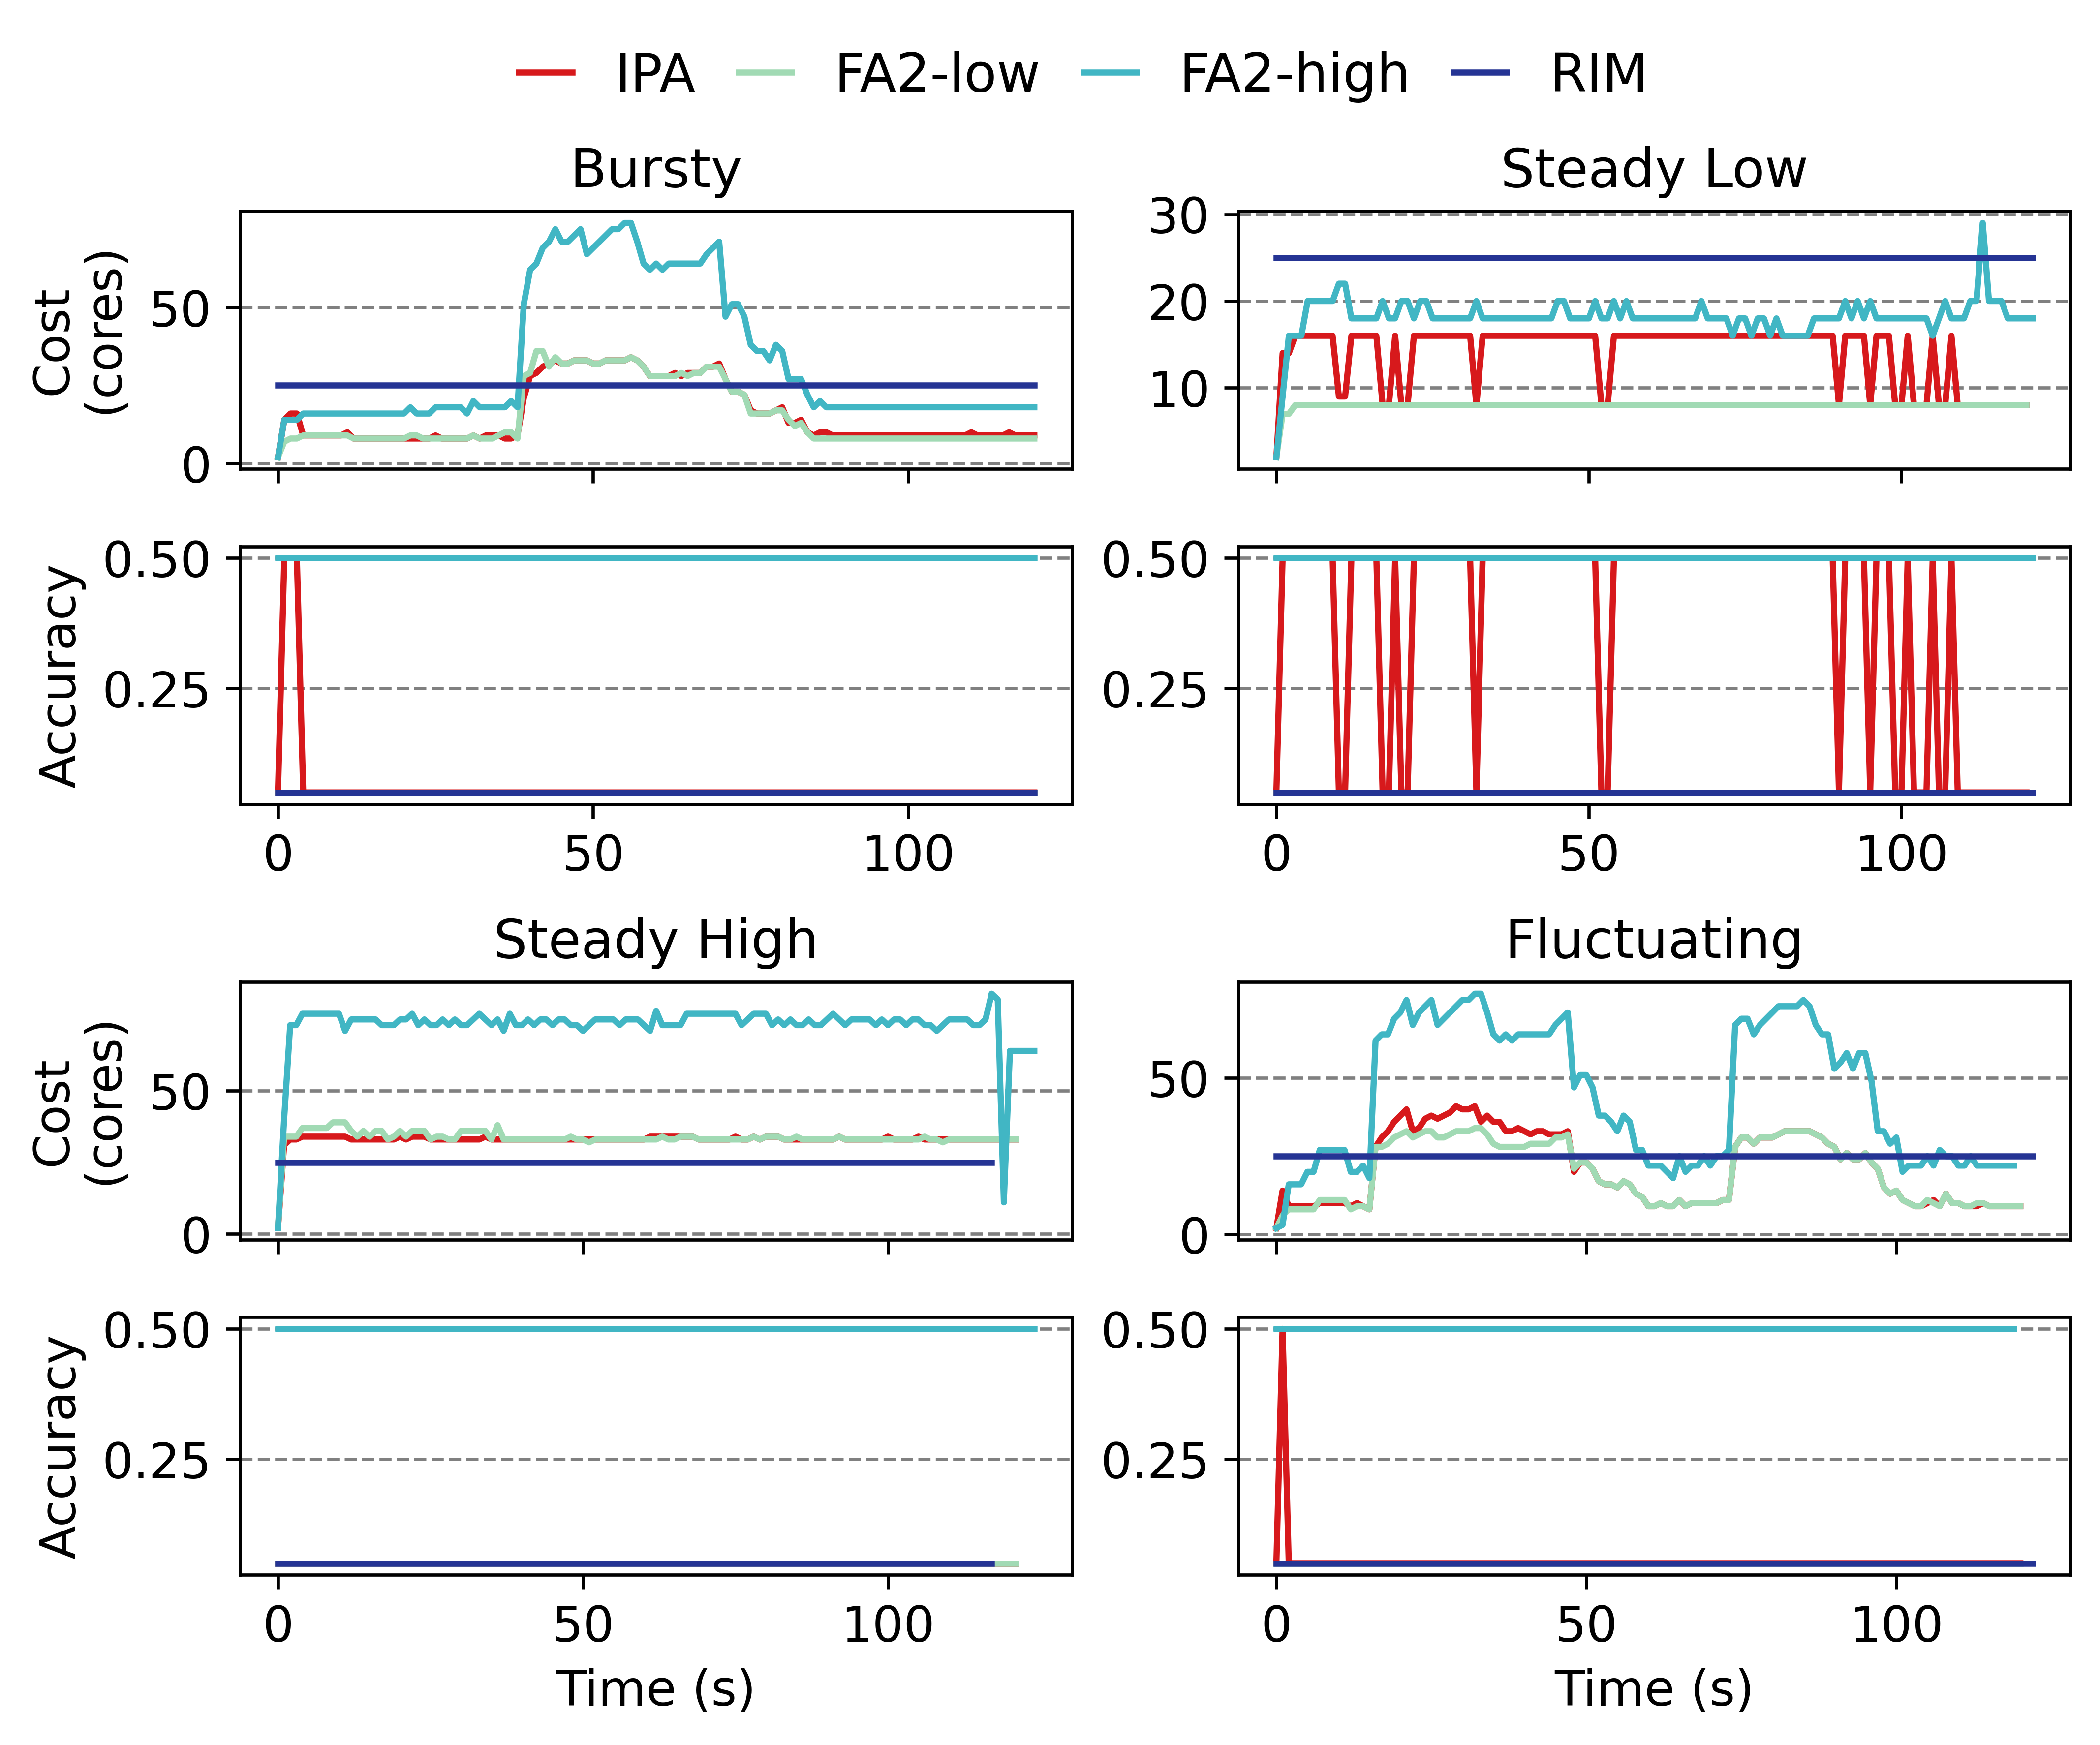

In [24]:
import importlib

importlib.reload(experiments.utils.drawing)
selected_experiments = {
    METRIC_TOTAL_CORE_CHANGES: {
        "selection": ["total"],
        "title": "Cost",
        "ylabel": "Cost\n (cores)",
    },
    METRIC_ACCURACY_CHANGES: {
        "selection": ["e2e"],
        "title": "Accuracy",
        "ylabel": "Accuracy",
    },
    METRIC_MEASURED_LATENCY: {
        "selection": [f"e2e_{latency_metric}"],
        "title": "Latency",
        "ylabel": "Latency (s)",
    },
    METRIC_TIMEOUT_DICS: {
        "selection": [f"timeout_per_second"],
        "title": "SLA Violations",
        "ylabel": "SLA\n Violations",
    },
}

# yellow: ffff99

serie_color = {
    "IPA": "#d7191c",
    "FA2-low": "#a1dab4",
    "FA2-high": "#41b6c4",
    "RIM": "#253494",
}

experiments.utils.drawing.draw_temporal_final4(
    final_by_load_type,
    adaptation_interval=adaptation_intervals,
    selected_experiments=selected_experiments,
    serie_color=serie_color,
    hl_for_metric={
        METRIC_MEASURED_LATENCY: {"value": 4, "color": "black", "label": "SLA"}
    },
    bbox_to_anchor=(0.55, 2.5 * len(METRICS_TO_PLOT) + 1.1),
    hspace=0.3,
    save=True,
    filename=f"{FIGURES_PATH}/metaseries-{metaseries}-{pipeline_name}.pdf",
)